# Bayesian vector autoregression forecasting

Author: Xinyu Chen (mail to: [chenxy346@gmail.com](chenxy346@gmail.com))

**About this notebook**:

> This notebook is aimed to introduce an unfamiliar reader to Bayesian modeling for vector autoregressive time series. While the vector autoregressive model is a quite simple case, the application of Gibbs sampling in this scenario follows the same principles as the implementation in a more complicated model (e.g., Bayesian temporal matrix factorization (BTMF)) and thus serves as a useful starting point. The reader should aim to become familiar with the following content:

- The basics of vector autoregressive model.
- Use Gaussian-Wishart distribution as a conjugate prior in Bayesian vector autoregression.
- Implement the Gibbs sampling algorithm for Bayesian vector autoregression in Python.
- Perform multivariate time series forecasting using Bayesian vector autoregression.

**Reference**:

- Sune Karlsson, 2012. [Forecasting with Bayesian Vector Autoregressions](https://www.oru.se/globalassets/oru-sv/institutioner/hh/workingpapers/workingpapers2012/wp-12-2012.pdf).
- Andrew Blake, Haroon Mumtaz, 2017. [Applied Bayesian econometrics for central bankers](https://www.bankofengland.co.uk/ccbs/applied-bayesian-econometrics-for-central-bankers-updated-2017) (handbook). Bank of England.

**Quick run**:

This notebook is publicly available for any usage at [**transdim**](https://github.com/xinychen/transdim) repository.


## 1 Vector autoregression (VAR) model

Vector autoregession (VAR) model is a type of time series model that describes the joint dynamics of multivariate time series data. Let $\boldsymbol{x}_{t}$ be a $R\times 1$ vector (time series variable) that takes values in $\mathbb{R}^{R}$, the temporal evolution of $\boldsymbol{x}_{t}$ can be described by the VAR(d):

$$\boldsymbol{x}_{t}=A_{1} \boldsymbol{x}_{t-h_1}+\cdots+A_{d}\boldsymbol{x}_{t-h_d}+\boldsymbol{\epsilon}_{t},~t=h_d+1,...,T,$$
where $d$ denotes the order of vector autoregressions. $A_{k}\in\mathbb{R}^{R\times R}$ are coefficient matrices and $\boldsymbol{\epsilon}_{t}\in\mathbb{R}^{R}$ is an unobservable zero mean white noise vector (with time invariant covariance matrix $\Lambda$).

For example, a bivariate VAR(2) model (e.g., time lags are $\left\{1,2\right\}$) has the form:

$$\begin{aligned}\left[\begin{array}{l}{x_{1 t}} \\ {x_{2 t}}\end{array}\right]=&+\left[\begin{array}{cc}{a_{11}^{(1)}} & {a_{12}^{(1)}} \\ {a_{21}^{(1)}} & {a_{22}^{(1)}}\end{array}\right]\left[\begin{array}{l}{x_{1 t-1}} \\ {x_{2 t-1}}\end{array}\right] +\left[\begin{array}{cc}{a_{11}^{(2)}} & {a_{12}^{(2)}} \\ {a_{21}^{(2)}} & {a_{22}^{(2)}}\end{array}\right]\left[\begin{array}{l}{x_{1 t-2}} \\ {x_{2 t-2}}\end{array}\right]+\left[\begin{array}{c}{\varepsilon_{1 t}} \\ {\varepsilon_{2 t}}\end{array}\right] \end{aligned}.$$

For better understanding vector autoregressions, we could rewrite the VAR(d) as the following form:

$$\boldsymbol{x}_{t}=A^\top{\boldsymbol{z}}_{t}+\boldsymbol{\epsilon}_{t},~t=h_d+1,...,T,$$
where we let

$$A=\left[A_1,A_2,...,A_d\right]^\top\in\mathbb{R}^{(Rd)\times R},$$
and 

$${\boldsymbol{z}}_{t}=\left[\begin{array}{l}{\boldsymbol{x}_{t-h_1}} \\ \vdots \\ {\boldsymbol{x}_{t-h_d}}\end{array}\right]\in\mathbb{R}^{(Rd)\times 1}.$$


## 2 Bayesian VAR

### 2.1 Bayesian setting

First of all, we assume that the time series observations are Gaussian distributed with

$$\boldsymbol{x}_{t}\sim\mathcal{N}\left(A^\top{\boldsymbol{z}}_{t},\Sigma\right),$$
where $\Sigma\in\mathbb{R}^{R\times R}$ is the covariance matrix multivariate normal distribution.

Given observations $\boldsymbol{x}_{h_d+1},...,\boldsymbol{x}_{T}$, we are interested in learning some autoregressive models, therefore, the goal is to learn coefficient matrix $A$ and covariance matrix $\Sigma$. In such case, we could take a Bayesian approach by placing conjugate priors on these parameters. The prior of $\Sigma$ is inverse-Wishart:

$$\Sigma\sim\mathcal{IW}\left(S_0,\nu_0\right)\propto|\Sigma|^{-\left(\nu_{0}+R+1\right) / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left(S_{0} \Sigma^{-1}\right)\right),$$
and the prior of coefficient matrix $A$ is a matrix normal distribution:

$$A\sim{\mathcal{M N}_{(R d) \times R}\left(M_{0}, \Psi_{0}, \Sigma\right)}{\propto|\Sigma|^{-R d / 2} \exp \left(-\frac{1}{2} \operatorname{tr}\left[\Sigma^{-1}\left(A-M_{0}\right) \Psi_{0}^{-1}\left(A-M_{0}\right)\right]\right)}$$

### 2.2 Posterior distribution

Before the following discussion, we first define

$$X=\left[\begin{array}{c}{\boldsymbol{x}_{h_d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-h_d) \times R},\quad Z=\left[\begin{array}{c}{\boldsymbol{x}_{d+1}^{\top}} \\ {\vdots} \\ {\boldsymbol{x}_{T}^{\top}}\end{array}\right] \in \mathbb{R}^{(T-d) \times(R d)},\quad \boldsymbol{z}_{t}=\left[\begin{array}{c}{\boldsymbol{x}_{t-1}} \\ {\vdots} \\ {\boldsymbol{x}_{t-h_d}}\end{array}\right] \in \mathbb{R}^{(R d) \times 1}.$$

For coefficient matrix $A\in\mathbb{R}^{(Rd)\times R}$ and covariance matrix $\Sigma\in\mathbb{R}^{R\times R}$, their posterior distributions are given as follows,

$$A \sim \mathcal{M} \mathcal{N}_{(R d) \times R}\left(M^{*}, \Psi^{*}, \Sigma\right), \quad \Sigma \sim \mathcal{I} \mathcal{W}\left(S^{*}, \nu^{*}\right),$$
where the parameters are

$$\begin{cases}\begin{array}{l}{\Psi^{*}=\left(\Psi_{0}^{-1}+Z^{\top} Z\right)^{-1}}, \\ {M^{*}=\Psi^{*}\left(\Psi_{0}^{-1} M_{0}+Z^{\top} X\right)}, \\ {S^{*}=S_{0}+S+\left(M_{0}-B\right)^{\top}\left(\Psi_{0}+\left(Z^{\top} Z\right)^{-1}\right)^{-1}\left(M_{0}-B\right)}, \\ {\nu^{*}=\nu_{0}+T-h_d},\end{array}\end{cases}$$
where we define two variables $B=\left(Z^{\top} Z\right)^{-1} Z^{\top} X\in \mathbb{R}^{(R d) \times R},~S=(X-Z B)^{\top}(X-Z B)\in\mathbb{R}^{R\times R}$.

### 2.3 Define Bayesian VAR (`bvar`) with `Numpy`

In [1]:
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import inv as inv

def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.rand(dim1, dim2)
    P = np.linalg.cholesky(U)
    Q = np.linalg.cholesky(V)
    return M + P @ X0 @ Q.T

def bvar(X, A, time_lags, multi_steps, burn_iter, gibbs_iter):
    """Bayesian vector autoregression (BVAR) with MNIW prior."""
    T, R = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : T, :]
    Q_mat = np.zeros((T - tmax, R * d))
    for k in range(d):
        Q_mat[:, k * R : (k + 1) * R] = X[tmax - time_lags[k] : T - time_lags[k], :]
    X_hat = np.zeros((multi_steps, gibbs_iter, R))
    for it in range(burn_iter + gibbs_iter):
        var_Psi0 = np.eye(R * d) + Q_mat.T @ Q_mat
        var_Psi = inv(var_Psi0)
        var_M = var_Psi @ Q_mat.T @ Z_mat
        var_S = np.eye(R) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
        Sigma = invwishart.rvs(df = R + T - tmax, scale = var_S)
        A = mnrnd(var_M, var_Psi, Sigma)
        if it + 1 > burn_iter:
            X_new = np.zeros((tmax + multi_steps, R))
            X_new[: tmax, :] = X[- tmax :, :]
            for t in range(multi_steps):
                X_new[tmax + t, :] = mvnrnd(A.T @ X_new[tmax + t - time_lags, :].reshape(R * d), Sigma)
            X_hat[:, it - burn_iter, :] = X_new[- multi_steps :, :]
                    
    return X_hat

### 2.4 Small experiment

Consider matrix $X\in\mathbb{R}^{20\times 3}$ that consists of
$$\boldsymbol{x}_{1}=(1,2,3,4,5,...,15,16,17,18,19,20)^\top$$
$$\boldsymbol{x}_{2}=(6,7,8,9,10,...,21,22,23,24,25)^\top$$
$$\boldsymbol{x}_{3}=(11,12,13,14,15,...,25,26,27,28,29,30)^\top$$

How to use `bvar` to forecast the following data points?

Ground truth:
$$\tilde{\boldsymbol{x}}_{1}=(21,22,23,24,25)^\top$$
$$\tilde{\boldsymbol{x}}_{2}=(26,27,28,29,30)^\top$$
$$\tilde{\boldsymbol{x}}_{3}=(31,32,33,34,35)^\top$$


In [2]:
X = np.zeros((20, 3))
for i in range(3):
    X[:, i] = np.arange(1 + 5 * i, 21 + 5 * i)

time_lags = np.arange(1, 6)
R = X.shape[1]
d = time_lags.shape[0]

burn_iter = 1000
gibbs_iter = 200
multi_steps = 5
A = np.random.randn(R * d, R)
X_hat = bvar(X, A, time_lags, multi_steps, burn_iter, gibbs_iter)

mat = np.zeros((5, 3))
for i in range(3):
    mat[:, i] = np.arange(21 + 5 * i, 26 + 5 * i)
mat_hat = np.mean(X_hat, axis = 1)
pos = np.where(mat != 0)
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos]) / mat[pos]) / mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2) / mat[pos].shape[0])))

MAPE: 0.014171125920282975
RMSE: 0.48847993093107084


In [3]:
print('Ground truth:')
print(mat)
print()
print('Predicted values:')
print(mat_hat)

Ground truth:
[[21. 26. 31.]
 [22. 27. 32.]
 [23. 28. 33.]
 [24. 29. 34.]
 [25. 30. 35.]]

Predicted values:
[[21.12567134 26.12160772 31.11115845]
 [22.169192   27.17841345 32.22316193]
 [23.29116925 28.33743066 33.42698484]
 [24.43432615 29.52667945 34.72150446]
 [25.68417465 30.80326915 35.97216395]]


## 3. Multivariate time series prediction/forecasting

There are a couple of advantages in performing prediction with Bayesian vector autoregression. One preferable advantage is that Bayesian vector autoregression allows us to incorporate uncertainty in parameter estimates which is particularly useful when performing prediction.


### 3.1 Toy example: Evaluation on temperature data

In the following, we use 5 time series from the temperature data collected in Pacific to evaluate Bayesian vector autoregression forecasting.

> [Pacific surface temperature](http://iridl.ldeo.columbia.edu/SOURCES/.CAC/). This data set collected monthly sea surface temperature on the Pacific over 396 consecutive months from January 1970 to December 2002. The spatial locations are expressed as grids of 2-by-2 degrees. The grid amount is $30\times 84$, and as a result, the temperature tensor is of size $30\times 84\times 396$.

In [4]:
import scipy.io

tensor = np.load('../datasets/Temperature-data-set/tensor.npy').astype(np.float32)
X = tensor[: 5, 0, : 12 * 40].T
X[np.where(X == 124)] = 0 # Outliers

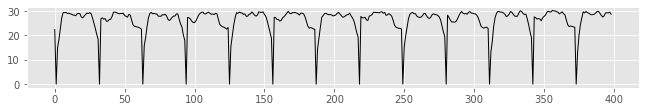

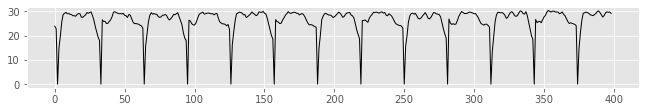

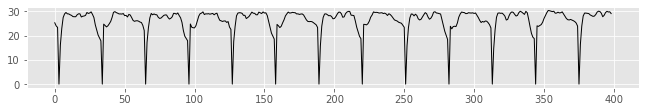

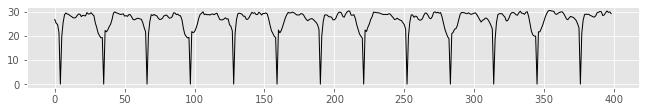

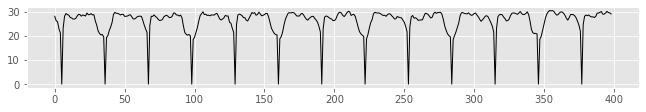

In [5]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
for i in range(5):
    fig = plt.figure(figsize = (10, 1.5))
    ax = fig.add_axes([0.10, 0.22, 0.85, 0.75])
    plt.plot(X[:, i], color = "black", linewidth = 1)
    plt.show()

In [6]:
import time
start = time.time()

time_lags = np.arange(1, 12 * 7 + 1)
R = X.shape[1]
d = time_lags.shape[0]

burn_iter = 1000
gibbs_iter = 200
multi_steps = 72
start_step = X.shape[0] - multi_steps
A = np.random.randn(R * d, R)
X_hat = bvar(X[: start_step, :], A, time_lags, multi_steps, burn_iter, gibbs_iter)

end = time.time()
print('Running time: %d seconds'%(end - start))

Running time: 13 seconds


In [7]:
mat = X[start_step : X.shape[0], :]
mat_hat = np.mean(X_hat, axis = 1)
pos = np.where(mat != 0)
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos]) / mat[pos]) / mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2) / mat[pos].shape[0])))

MAPE: 0.12884303248330892
RMSE: 5.2782887128147316


### 3.2 Analysis of prediction results

Bayesian vector autroegression forecasting provide an efficient way not only to obtain point estimates but also to characterise the uncertainty around those point estimates.

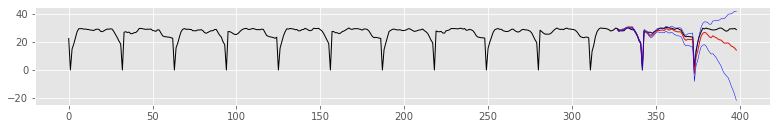

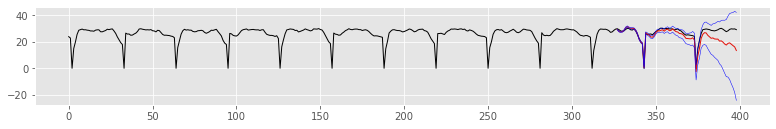

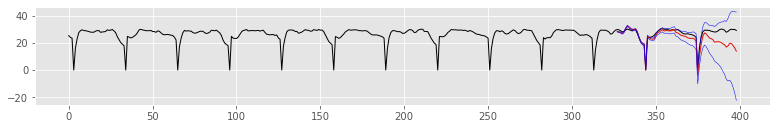

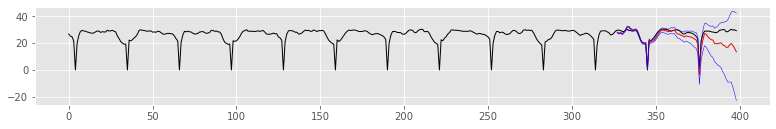

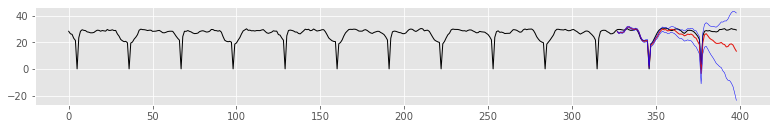

In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
for i in range(5):
    fig = plt.figure(figsize = (12, 2))
    ax = fig.add_axes([0.13, 0.28, 0.85, 0.68])
    plt.plot(X[:, i], color = "black", linewidth = 1)
    horizon = list(range(X.shape[0] - multi_steps, X.shape[0]))
    plt.plot(horizon, mat_hat[:, i], color = "#e3120b", linewidth = 1.0)
    plt.plot(horizon, np.percentile(X_hat[:, :, i], 10, axis = 1), color = "blue", linewidth = 0.5)
    plt.plot(horizon, np.percentile(X_hat[:, :, i], 90, axis = 1), color = "blue", linewidth = 0.5)

- Black curves: Ground truth
- Red curves: Multi-step prediction values with given time horizon
- Blue curves (uncertainty): Use the 10 and 90 percentiles of the forecasts as credible intervals

### 3.3 Evaluation on traffic data

In the following, we use 3 time series from the traffic speed data collected in Guangzhou, China to evaluate Bayesian vector autoregression forecasting.

> [Guangzhou urban traffic speed](https://doi.org/10.5281/zenodo.1205229). This data set registered traffic speed data from 214 road segments over two months (61 days from August 1 to September 30, 2016) with a 10-minute resolution (144 time intervals per day) in Guangzhou, China. We organize the raw data set into a time series matrix of $214\times 8784$ and there are 1.29% missing values.

In [9]:
import scipy.io

tensor = scipy.io.loadmat('../datasets/Guangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
X = dense_mat[3 : 6, : 7 * 144].T

start = time.time()

time_lags = np.array([1, 2, 144])
R = X.shape[1]
d = time_lags.shape[0]

burn_iter = 1000
gibbs_iter = 200
multi_steps = 144
start_step = X.shape[0] - multi_steps
A = np.random.randn(R * d, R)
X_hat = bvar(X[: start_step, :], A, time_lags, multi_steps, burn_iter, gibbs_iter)

end = time.time()
print('Running time: %d seconds'%(end - start))

Running time: 3 seconds


In [10]:
mat = X[start_step : X.shape[0], :]
mat_hat = np.mean(X_hat, axis = 1)
pos = np.where(mat != 0)
print('MAPE: {}'.format(np.sum(np.abs(mat[pos] - mat_hat[pos]) / mat[pos]) / mat[pos].shape[0]))
print('RMSE: {}'.format(np.sqrt(np.sum((mat[pos] - mat_hat[pos]) ** 2) / mat[pos].shape[0])))

MAPE: 0.1060068460530468
RMSE: 4.347877063062124


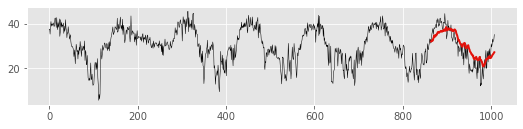

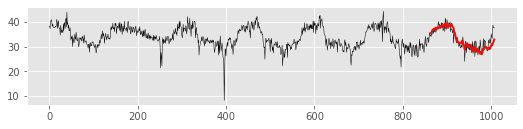

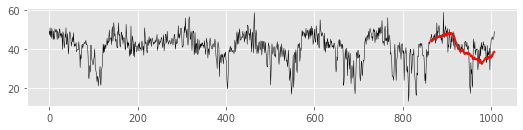

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
for i in range(3):
    fig = plt.figure(figsize = (8, 2))
    ax = fig.add_axes([0.13, 0.28, 0.85, 0.68])
    plt.plot(X[:, i], color = "black", linewidth = 0.5)
    horizon = list(range(X.shape[0] - multi_steps, X.shape[0]))
    plt.plot(horizon, mat_hat[:, i], color = "#e3120b", linewidth = 2.0)

There are some limitations to Bayesian vector autoregression forecasting:

- **Difficult to handle high-dimensional multivariate time series** because Bayesian vector autoregression model would have a large number of parameters.

- **Cannot handle the time series data with missing values** because Bayesian vector autoregression model needs to learn from fully observed data.

> We have tried our best to make everything as simple as possible, while still providing the depth and breadth required to be useful in research. If you have any suggestions or comments, please feel free to contact Xinyu Chen (mail to [chenxy346@gmail.com](chenxy346@gmail.com)) or create an issue [here](https://github.com/xinychen/transdim/issues).

### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>